In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pyrepseq as prs
from pyrepseq.metric.tcr_metric import TcrMetric
import pandas as pd
from pandas import DataFrame
import random
from sceptr import variant
from sceptr._lib.sceptr import Sceptr
from sklearn import metrics
from typing import List

## Prep objects

In [2]:
LABELLED_DATA = pd.read_csv("../tcr_data/preprocessed/benchmarking/vdjdb_cleaned.csv")
BACKGROUND_DATA = pd.read_csv("../tcr_data/preprocessed/tanno/test.csv")
BACKGROUND_SAMPLE = BACKGROUND_DATA.sample(n=1000,random_state=420)

EPITOPES = LABELLED_DATA.Epitope.unique()

models = (
    prs.metric.tcr_metric.Tcrdist(),
    variant.ab_sceptr()
)

In [3]:
def convert_dists_to_scores(dists: ndarray) -> ndarray:
    max_dist = np.max(dists)
    return 1 - dists / max_dist

class FewShotPredictor:
    def __init__(self, metric: TcrMetric, positive_refs: DataFrame, bg_refs: DataFrame) -> None:
        self._metric = metric
        self._positive_refs = positive_refs
        self._bg_refs = bg_refs
    
    def get_nn_inferences(self, queries: DataFrame) -> ndarray:
        cdist_matrix = self._metric.calc_cdist_matrix(queries, self._positive_refs)
        nn_dists = np.min(cdist_matrix, axis=1)
        return convert_dists_to_scores(nn_dists)
    
    def get_avg_dist_inferences(self, queries: DataFrame) -> ndarray:
        cdist_matrix = self._metric.calc_cdist_matrix(queries, self._positive_refs)
        avg_dists = np.mean(cdist_matrix, axis=1)
        return convert_dists_to_scores(avg_dists)

In [22]:
def get_benchmark_results(model: TcrMetric) -> dict:
    benchmark_results = dict()
    
    benchmark_results["one_shot"] = get_oneshot_benchmark_results(model)
    
    

    return benchmark_results

def get_oneshot_benchmark_results(model: TcrMetric) -> DataFrame:
    results = []

    for epitope in EPITOPES:
        labelled_data_epitope_mask = LABELLED_DATA.Epitope == epitope
        epitope_references = LABELLED_DATA[labelled_data_epitope_mask]
        cdist_matrix = model.calc_cdist_matrix(LABELLED_DATA, epitope_references)

        aucs = []
        auc01s = []
        for cdist_idx, tcr_idx in enumerate(epitope_references.index):
            dists = cdist_matrix[:,cdist_idx]
            similarities = convert_dists_to_scores(dists)

            similarities = np.delete(similarities, tcr_idx)
            ground_truth = np.delete(labelled_data_epitope_mask, tcr_idx)

            aucs.append(metrics.roc_auc_score(ground_truth, similarities))
            auc01s.append(metrics.roc_auc_score(ground_truth, similarities, max_fpr=0.1))

        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        mean_auc01 = np.mean(auc01s)
        std_auc01 = np.mean(auc01s)

        results.append({"epitope": epitope, "mean_auc": mean_auc, "std_auc": std_auc, "mean_auc01": mean_auc01, "std_auc01": std_auc01})
    
    return DataFrame.from_records(results)

# def get_few_shot_aucs(model: TcrMetric, epitope: str, num_shots: int) -> List[float]:
#     test_data_epitope_mask = test_data.Epitope == epitope
#     epitope_references = test_data[test_data_epitope_mask]

#     if len(epitope_references)- num_shots < 100:
#         return []

#     random_subsets = [
#         random.sample(epitope_references.index.to_list(), k=num_shots) for _ in range(100)
#     ]

#     aucs = []
#     for subset_indices in random_subsets:
#         epitope_reference_subset = epitope_references.loc[subset_indices]
#         cdist_matrix = model.calc_cdist_matrix(epitope_reference_subset, test_data)
#         similarity_matrix = np.exp(-cdist_matrix/20)
#         similarities = np.mean(similarity_matrix, axis=0)

#         similarities = np.delete(similarities, subset_indices)
#         ground_truth = np.delete(test_data_epitope_mask, subset_indices)

#         aucs.append(metrics.roc_auc_score(ground_truth, similarities))
    
#     return aucs

In [20]:
benchmarks_per_metric = {
    model.name: get_benchmark_results(model) for model in models
}

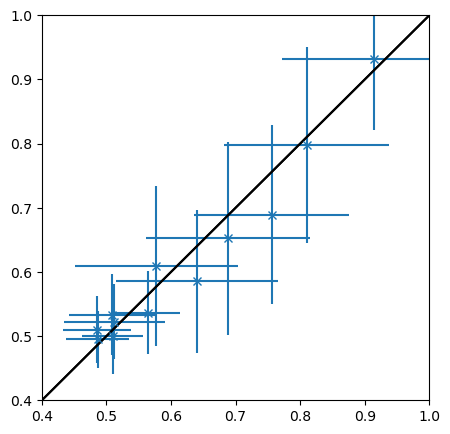

In [27]:
sceptr_aucs = benchmarks_per_metric["AB SCEPTR"]["one_shot"]
tcrdist_aucs = benchmarks_per_metric["tcrdist"]["one_shot"]

plt.figure(figsize=(5,5))
plt.errorbar(x=tcrdist_aucs["mean_auc"], y=sceptr_aucs["mean_auc"], xerr=tcrdist_aucs["std_auc"], yerr=sceptr_aucs["std_auc"], fmt="x")
plt.plot(((0,0),(1,1)), c="k")
plt.xlim(0.4,1)
plt.ylim(0.4,1)
plt.show()